In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.optim import lr_scheduler

from random import *
from collections import defaultdict

import os
import cv2
import copy
import time
from random import *
from collections import defaultdict

In [2]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Cutout, Rotate, HorizontalFlip
)
from albumentations.pytorch import ToTensor

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head()

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2


In [5]:
dummy_train = pd.get_dummies(train, columns=['letter'])

In [6]:
dummy_train.head()

,id,digit,0,1,2,3,4,5,6,7,...,letter_Q,letter_R,letter_S,letter_T,letter_U,letter_V,letter_W,letter_X,letter_Y,letter_Z
0,1,5,1,1,1,4,3,0,0,4,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,4,0,0,4,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,3,4,1,1,2,2,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,9,1,2,0,2,0,4,0,3,...,0,0,0,0,0,0,0,0,0,0
4,5,6,3,0,2,4,0,3,0,4,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# def make_folder(directory):
#     if not os.path.isdir(directory):
#         os.mkdir(directory)

# path_train = os.path.join(os.getcwd(), 'emnist2/train')
# path_val = os.path.join(os.getcwd(), 'emnist2/val')
# path_test = os.path.join(os.getcwd(), 'emnist2/test')

In [8]:
# make_folder(path_train)
# make_folder(path_val)
# make_folder(path_test)

In [9]:
# for i in range(len(train)):
#     digit = train.loc[i, 'digit']
#     letter = train.loc[i, 'letter']
#     img = train.loc[i, '0':].values.reshape(28, 28).astype(int)

#     path_train_image = os.path.join(path_train, '%d_%c.jpg'%(i, letter))
#     path_val_image = os.path.join(path_val, '%d_%c.jpg'%(i, letter))
#     ran_num = randint(0,4)

#     if ran_num ==0:
#         cv2.imwrite(path_val_image, img)
#     else:
#         cv2.imwrite(path_train_image, img)

# for i in range(len(test)):
#     letter = test.loc[i, 'letter']
#     img = test.loc[i, '0':].values.reshape(28, 28).astype(int)
    
#     path_test_digit = os.path.join(path_test, '%d_%c.jpg'%(i, letter))
#     cv2.imwrite(path_test_digit, img)

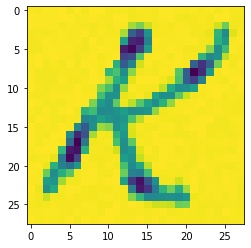

In [10]:
idx = np.random.randint(len(dummy_train))
img = dummy_train.iloc[idx]['0':'783'].values
img = img.reshape(28, 28).astype(np.uint8)
img = 255 - img
img = img[:, :, np.newaxis]
plt.imshow(img)
plt.show()

In [11]:
label1 = dummy_train.iloc[idx]['letter_A':'letter_Z'].values
label2 = dummy_train.iloc[idx].digit

In [12]:
print(label1)
print(label2)

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0


## 데이터셋 만들기

In [100]:
class EMNISTDataset(Dataset):
    def __init__(self, csv, img_height, img_width):
        self.csv = csv.reset_index()
        self.img_ids = csv['id'].values
        self.img_height = img_height
        self.img_width = img_width
        
    def __len__(self):
        return len(self.csv)

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img = self.csv.iloc[img_id]['0':'783'].values
        img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
        img = 255 - img
        img = img[:, :, np.newaxis]
        img = np.repeat(img, 3, 2)
        
        letter = self.csv.iloc[index]['letter_A':'letter_Z'].values
        digit = self.csv.iloc[index]['digit']
        
        return (torch.tensor(img, dtype=torch.float).permute(2, 0, 1),
                 torch.tensor(letter, dtype=torch.float),
                 torch.tensor(digit, dtype=torch.float))

In [101]:
trn_fold = [i for i in range(10) if i not in [5]]
val_fold = [5]

trn_idx = dummy_train.loc[dummy_train['digit'].isin(trn_fold)].index
val_idx = dummy_train.loc[dummy_train['digit'].isin(val_fold)].index

In [102]:
len(trn_idx)

1823

In [103]:
len(val_idx)

225

In [104]:
trn_dset = EMNISTDataset(csv=dummy_train.loc[trn_idx], img_height=28, img_width=28)
val_dset = EMNISTDataset(csv=dummy_train.loc[val_idx], img_height=28, img_width=28)

In [105]:
print(trn_dset[0])

(tensor([[[254., 253., 255.,  ..., 253., 253., 255.],
         [253., 255., 252.,  ..., 253., 253., 254.],
         [255., 253., 253.,  ..., 251., 252., 251.],
         ...,
         [251., 255., 254.,  ..., 254., 255., 255.],
         [253., 251., 252.,  ..., 254., 254., 254.],
         [253., 253., 253.,  ..., 255., 254., 254.]],

        [[254., 253., 255.,  ..., 253., 253., 255.],
         [253., 255., 252.,  ..., 253., 253., 254.],
         [255., 253., 253.,  ..., 251., 252., 251.],
         ...,
         [251., 255., 254.,  ..., 254., 255., 255.],
         [253., 251., 252.,  ..., 254., 254., 254.],
         [253., 253., 253.,  ..., 255., 254., 254.]],

        [[254., 253., 255.,  ..., 253., 253., 255.],
         [253., 255., 252.,  ..., 253., 253., 254.],
         [255., 253., 253.,  ..., 251., 252., 251.],
         ...,
         [251., 255., 254.,  ..., 254., 255., 255.],
         [253., 251., 252.,  ..., 254., 254., 254.],
         [253., 253., 253.,  ..., 255., 254., 254.]]

## Albumentation 기법 적용

In [106]:
train_transforms = Compose([
    Rotate(20),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MotionBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
    ToTensor(),
], p=1.0)

# validation은 Augmentation을 해주지 않는 것이 좋다
valid_transforms = Compose([
    ToTensor(),
])

In [113]:
class EMNISTDataset(Dataset):
    def __init__(self, csv, img_height, img_width, transform=None):
        self.csv = csv.reset_index()
        self.img_ids = self.csv['id'].values
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img = self.csv.iloc[img_id]['0':'783'].values
        img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
        img = 255 - img
        img = img[:, :, np.newaxis]
        img = np.repeat(img, 3, 2)
        
        if self.transform is not None:
            img = self.transform(image=img)['image']
        
        letter = self.csv.iloc[index]['letter_A':'letter_Z'].values.reshape(-1, 26)
        digit = self.csv.iloc[index]['digit']
        
        return letter, img, digit

(28, 28, 3)
torch.Size([3, 28, 28])


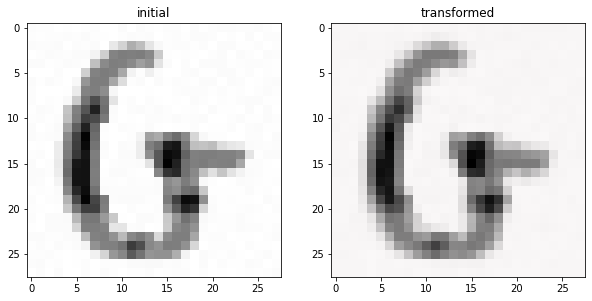

In [114]:
idx = np.random.randint(len(dummy_train))
img2 = dummy_train.iloc[idx]['0':'783'].values
img2 = img2.reshape(28, 28).astype(np.uint8)
img2 = 255 - img2
img2 = img2[:, :, np.newaxis]
img2 = np.repeat(img2, 3, 2)
print(img2.shape)

img2_tr = train_transforms(image=img2)['image']
print(img2_tr.shape)

f, ax = plt.subplots(1, 2, figsize=(10, 16))
ax[0].imshow(img2)
ax[1].imshow(img2_tr.permute(1, 2, 0))
ax[0].set_title('initial')
ax[1].set_title('transformed')

plt.show()

In [115]:
trn_dset_transformed = EMNISTDataset(csv=dummy_train.loc[trn_idx], img_height=28, img_width=28, transform=train_transforms)
val_dset_trnasformed = EMNISTDataset(csv=dummy_train.loc[val_idx], img_height=28, img_width=28, transform=valid_transforms)

In [116]:
print(trn_dset_transformed[1])

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]], dtype=int64), tensor([[[0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         [0.9882, 0.9882, 0.9922,  ..., 0.9922, 0.9922, 0.9882],
         [0.9922, 0.9922, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         ...,
         [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9961],
         [0.9961, 0.9922, 0.9922,  ..., 0.9882, 0.9882, 0.9922],
         [0.9922, 0.9922, 0.9922,  ..., 0.9882, 0.9804, 0.9922]],

        [[0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         [0.9882, 0.9882, 0.9922,  ..., 0.9922, 0.9922, 0.9882],
         [0.9922, 0.9922, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         ...,
         [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9961],
         [0.9961, 0.9922, 0.9922,  ..., 0.9882, 0.9882, 0.9922],
         [0.9922, 0.9922, 0.9922,  ..., 0.9882, 0.9804, 0.9922]],

        [[0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         [0.

In [117]:
print(val_dset_trnasformed[1])

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0]], dtype=int64), tensor([[[0.9922, 0.9922, 0.9961,  ..., 1.0000, 0.9843, 0.9961],
         [0.9922, 0.9922, 1.0000,  ..., 0.9882, 0.9882, 0.9961],
         [0.9882, 0.9922, 1.0000,  ..., 1.0000, 0.9843, 0.9843],
         ...,
         [0.9843, 1.0000, 0.9843,  ..., 1.0000, 0.9961, 0.9882],
         [0.9843, 0.9843, 0.9843,  ..., 0.9922, 0.9882, 0.9961],
         [0.9922, 0.9843, 0.9843,  ..., 0.9922, 0.9922, 0.9961]],

        [[0.9922, 0.9922, 0.9961,  ..., 1.0000, 0.9843, 0.9961],
         [0.9922, 0.9922, 1.0000,  ..., 0.9882, 0.9882, 0.9961],
         [0.9882, 0.9922, 1.0000,  ..., 1.0000, 0.9843, 0.9843],
         ...,
         [0.9843, 1.0000, 0.9843,  ..., 1.0000, 0.9961, 0.9882],
         [0.9843, 0.9843, 0.9843,  ..., 0.9922, 0.9882, 0.9961],
         [0.9922, 0.9843, 0.9843,  ..., 0.9922, 0.9922, 0.9961]],

        [[0.9922, 0.9922, 0.9961,  ..., 1.0000, 0.9843, 0.9961],
         [0.

## 데이터로더 만들기

In [118]:
trn_dloader = DataLoader(trn_dset_transformed, shuffle=True, batch_size=32)
val_dloader = DataLoader(val_dset_trnasformed, shuffle=False, batch_size=32)

In [120]:
for letter, image, digit in trn_dloader:
    break

IndexError: single positional indexer is out-of-bounds

In [31]:
print(letter.shape)
print(image.shape)
print(digit.shape)

NameError: name 'letter' is not defined

## 모델 만들기

In [ ]:
class customCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Letter의 Convolution Block
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1), nn.ReLU(), # 16@26
            nn.Conv1d(16, 64, 4, padding=1), nn.ReLU(), # 64@25
            nn.Conv1d(64, 128, 5, padding=2), nn.ReLU(), # 128@25
            nn.Conv1d(128, 64, 4, padding=2), nn.ReLU(), # 64@26
            nn.Conv1d(64, 16, 3), nn.ReLU(), # 16@24
        )
        
        # Image의 Convolution Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), # 32@28x28
            nn.Conv2d(32, 128, 5, padding=2), nn.ReLU(), # 128@28x28
            nn.Conv2d(128, 256, 7, padding=3), nn.ReLU(), # 256@28x28
            nn.Conv2d(256, 512, 9, padding=3), nn.ReLU(), # 512@26x26
            nn.Conv2d(512, 256, 9, padding=3), nn.ReLU(), # 256@24x24
            nn.Conv2d(256, 128, 7, padding=3), nn.ReLU(), # 128@24x24
            nn.Conv2d(128, 64, 7, padding=3), nn.ReLU(), # 64@24x24
            nn.Conv2d(64, 32, 5, padding=3), nn.ReLU(), # 32@26x26
        )
        
        self.out = nn.Sequential(
            nn.Linear(22016, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Linear(32, 10)
        )
        
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, x1, x2, label=False):
        out = self._inference(x1, x2)
        if label is not False:
            loss = self.loss(out, label)
            return (out, loss)
        
        return out
    
    def _inference(self, x1, x2):
        bsz = x1.size(0)
#         print('bsz: ', bsz)
        x1 = self.conv1(x1)
#         print('x1 shape: ', x1.shape) # [32, 16, 24]
        x2 = self.conv2(x2)
#         print('x2 shape: ', x2.shape) # [32, 32, 26, 26]
        
        x1 = x1.view(bsz, -1)
#         print('x1 shape: ', x1.shape) # [32, 384]
        x2 = x2.view(bsz, -1)
#         print('x2 shape: ', x2.shape) # [32, 21632]
        
        x = torch.cat([x1, x2], dim=1)
        out = torch.nn.functional.softmax(self.out(x), dim=1)
        
        return out

In [ ]:
model = customCNN()
model.cuda()

In [ ]:
test_letter = Variable(letter.float()).cuda()
test_image = Variable(image.float()).cuda()

In [ ]:
print(test_letter.shape)
print(test_image.shape)

In [ ]:
model(test_letter, test_image)

## 모델 훈련

In [ ]:
from torch.optim import Adam

optimizer = Adam(
    model.parameters(),
    lr=2e-5,
    eps=1e-8,
)

In [ ]:
epochs = 150
seed_val = 42
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda')
print(device)

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
for step, batch in enumerate(trn_dloader):
    letter, image, digit = batch
    print(letter.shape)
    print(image.shape)
    print(digit.shape)
    print(digit)
    break

In [ ]:
# gradient 초기화
model.zero_grad()

history = defaultdict(list)
for epoch_i in range(0, epochs):
    
    total_loss = 0
    
    # train 모드로 변경
    model.train()
    
    # dataloader에서 batch size만큼 반복해서 가져옴
    for step, batch in enumerate(trn_dloader):
        
        # batch를 GPU에 적용
        batch = tuple(t.to(device) for t in batch)
        
        # batch에서 데이터 추출
        letter, image, label = batch
        
        letter = Variable(letter.float())
        image = Variable(image.float())
        label = Variable(label.long())
        
        # Forward Propagation 수행
        outputs = model(letter, image, label)
        
        loss = outputs[1]
        
        total_loss += loss.item()
        
        # Backward Propagation 수행
        loss.backward()
        history["train_loss"].append(loss.item())
        
        # 정확도 계산
        logits = outputs[0].detach().cpu().numpy()
        label = label.to("cpu").numpy()
        tmp_train_accuracy = flat_accuracy(logits, label)
        history["train_acc"].append(tmp_train_accuracy)
        
        # Gradient Cleeping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # gradient를 통해 weight update
        optimizer.step()
        
        # gradient 초기화
        model.zero_grad()
        
    # average loss
    avg_train_loss = total_loss / len(val_dloader)
    
    # ========================================
    #               Validation
    # ========================================
    
    t0 = time.time()
    
    # eval 모드로 변경
    model.eval()
    
    # 변수 초기화
    eval_loss, eval_accuracy, nb_eval_steps, nb_eval_examples = 0, 0, 0, 0
    
    # dataloader에서 batch만큼 반복해서 가져옴
    for batch in val_dloader:
        
        # batch를 GPU에 적용
        batch = tuple(t.to(device) for t in batch)
        
        # batch에서 데이터 추출
        letter, image, label = batch
        
        letter = Variable(letter.float())
        image = Variable(image.float())
        label = Variable(label.long())
        
        # gradient 계산 안함
        with torch.no_grad():
            # Forward Propagation 수행
            outputs = model(letter, image, label)
        
        logits = outputs[0]
        history["eval_loss"].append(outputs[1].item())
        
        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label = label.to("cpu").numpy()
        
        # 출력 logit과 label을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label)
        history["eval_acc"].append(tmp_eval_accuracy)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
        
    s = f"\r[Epoch {epoch_i+1}/{epochs}]"
    s += f" Avg Training Loss: {avg_train_loss: .2f}"
    s += " Valid Acc: {0:.2f}".format(eval_accuracy / nb_eval_steps)
    print(s, end="")
    
print("")
print("Training complete")